# Phase Field Benchmark 8c
## Explicit nucleation, multiple seeds at random times
FiPy implementation of problem 3 in *Nucleation Benchmark Problem*, Wenkun Wu *et al.*, January 16, 2020

Based on problem 2.3 in *Benchmark problems for nucleation*, Tamás Pusztai, September 25, 2019

Revised to [PFHub statement](https://pages.nist.gov/pfhub/benchmarks/benchmark8.ipynb/#Part-%28c%29)

**Do not edit `nucleation.py`**. Generate the batch-runnable file from the notebook with
```bash
jupyter nbconvert nucleation.ipynb --to python
```

## Import Python modules

In [228]:
import argparse
import os
import re
import sys

import fipy as fp
from fipy.tools import numerix as nmx
from fipy.tools import parallelComm

Jupyter notebook handles some things differently than from the commandline

In [229]:
try:
    from IPython import get_ipython
    isnotebook = get_ipython() is not None
except:
    isnotebook = False

## Initialize
### Load parameters

In [230]:
parser = argparse.ArgumentParser()
parser.add_argument("--output", help="directory to store results in",
                    default=os.getcwd())
parser.add_argument("--store_by_solver",
                    help="store results in nested subdirectories based on solver,"
                    "preconditioner, and system size",
                    action='store_true')
parser.add_argument("--restart", help="solution to initialize from",
                    default=None)
parser.add_argument("--checkpoint_interval", help="frequency to save results",
                    type=float, default=6.)
parser.add_argument("--totaltime", help="duration of full simulation",
                    type=float, default=600.)
parser.add_argument("--numnuclei", help="number of nuclei",
                    type=int, default=100)
parser.add_argument("--factor", help="fraction of critical nucleus size for new nuclei",
                    type=float, default=1.1)
parser.add_argument("--nucleation_scale", help="size of domain for nuclei",
                    type=float, default=1000)
parser.add_argument("--numberOfElements", help="number of total cells in a Grid2D",
                    type=int, default=1000000)
parser.add_argument("--solver", help="solver class to use",
                    choices=("pcg", "cgs", "gmres", "lu"), default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use",
                    choices=("jacobi", "ilu", "ssor", "icc", "none"), default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)
parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    type=float, default=1e-10)

_StoreAction(option_strings=['--tolerance'], dest='tolerance', nargs=None, const=None, default=1e-10, type=<class 'float'>, choices=None, help='linear solver tolerance', metavar=None)

### Set any parameters for interactive notebook

In [245]:
if isnotebook:
    # argv = ["--numberOfElements=10000", "--totaltime=1.2", "--checkpoint_interval=0.12",
    #         "--nucleation_scale=100", "--output=nucleation6"]
    argv = ["--numberOfElements=10000", "--nucleation_scale=100", "--output=nucleation16"]
else:
    argv = None

In [246]:
args, unknowns = parser.parse_known_args(args=argv)

### Initialize mesh and solution variables

Either restart from some `path/to/restart/t={time}.npz`, where the time is assigned to `elapsed`

or

Create a mesh based on parameters. Set
>  the computational domain is ... 1000×1000 

In [247]:
nx = ny = int(nmx.sqrt(args.numberOfElements))
mesh = fp.Grid2D(nx=nx, ny=ny)
phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=0., hasOld=True)
elapsed = 0.

In [248]:
if args.restart is not None:
    data = nmx.load(args.restart)
    phi.setValue(data["phi"][:nx, :ny].flat)

    # scanf("%g") simulator
    # https://docs.python.org/3/library/re.html#simulating-scanf
    scanf_g = "[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pattern = ".*t=({g})\.npz".format(g=scanf_g)
    elapsed = float(re.match(pattern, args.restart).group(1))

In [249]:
x, y = mesh.cellCenters[0], mesh.cellCenters[1]
X, Y = mesh.faceCenters[0], mesh.faceCenters[1]

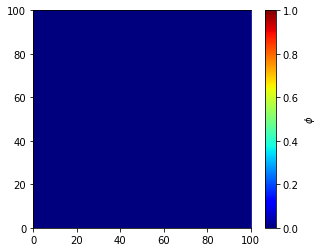

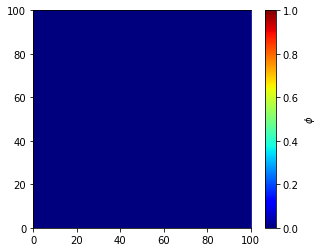

In [250]:
if isnotebook:
    viewer = fp.Viewer(vars=phi, datamin=0., datamax=1.)
    viewer.plot()

## Create solver

In [251]:
precon = None

if args.preconditioner == "jacobi":
    precon = fp.JacobiPreconditioner()
elif args.preconditioner == "ilu":
    precon = fp.ILUPreconditioner()
elif args.preconditioner == "ssor":
    precon = fp.SSORPreconditioner()
elif args.preconditioner == "icc":
    precon = fp.ICPreconditioner()
elif args.preconditioner == "none":
    precon = None

if args.solver == "cgs":
    solver_class = fp.LinearCGSSolver
elif args.solver == "gmres":
    solver_class = fp.LinearGMRESSolver
elif args.solver == "lu":
    if args.preconditioner != "none":
        # preconditioned lu doesn't make any sense
        exit()

    solver_class = fp.LinearLUSolver
elif args.solver == "pcg":
    solver_class = fp.LinearPCGSolver

solver = solver_class(tolerance=args.tolerance, criterion="initial",
                      iterations=args.iterations, precon=precon)

## Define governing equation

> use only the nondimensional forms of the phase-field and nucleation equations, but without the tildes, for simplicity

> [Set] the driving force to $\Delta f = 1 / (6\sqrt{2})$

In [252]:
Delta_f = 1. / (6 * nmx.sqrt(2.))

> $$r_c = \frac{1}{3\sqrt{2}}\frac{1}{\Delta f} = 2.0$$

In [253]:
rc = 2.0

and define the governing equation 
> \begin{align}
\frac{\partial\phi}{\partial t} &= \nabla^2\phi - g'(\phi) + \Delta f p'(\phi) \tag{7}
\end{align}

> $$g(\phi) = \phi^2(1 - \phi)^2 \qquad p(\phi)=\phi^3(10 - 15\phi + 6\phi^2)$$

Following [`examples/phase/simple.py`](https://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.simple.html)


\begin{align}
\frac{\partial\phi}{\partial t}
&= \nabla^2\phi + m_\phi \phi (1 - \phi) \notag
\qquad\text{for $m_\phi \equiv -2(1 - 2\phi) + 30 \phi (1 - \phi) \Delta f$} \notag
\\
&= \nabla^2\phi + S \notag
\\
&\approx \nabla^2\phi + S|_\text{old}
+ \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} (\phi - \phi_\text{old}) 
\notag \\
&= \nabla^2\phi + \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old} 
+ \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} \phi \notag
\\
&= \nabla^2\phi + S_0 + S_1 \phi \notag
\\
S_0 &\equiv \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old}
\notag \\
&= m_\phi \phi_\text{old} (1 - \phi_\text{old}) - S_1 \phi_\text{old}
\notag \\
S_1 &\equiv \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old}
\notag \\
&= \frac{\partial m_\phi}{\partial \phi} \phi (1 - \phi) + m_\phi (1 - 2\phi)
\notag
\end{align}

In [254]:
mPhi = -2 * (1 - 2 * phi) + 30 * phi * (1 - phi) * Delta_f
dmPhidPhi = 4 + 30 * (1 - 2 * phi) * Delta_f
S1 = dmPhidPhi * phi * (1 - phi) + mPhi * (1 - 2 * phi)
S0 = mPhi * phi * (1 - phi) - S1 * phi

eq = (fp.TransientTerm() == 
      fp.DiffusionTerm(coeff=1.) + S0 + fp.ImplicitSourceTerm(coeff=S1))

## Calculate total free energy

> \begin{align}
F[\phi] = \int\left[\frac{1}{2}(\nabla\phi)^2 + g(\phi) - \Delta f p(\phi)\right]\,dV \tag{6}
\end{align}

In [255]:
ftot = (0.5 * phi.grad.mag**2
        + phi**2 * (1 - phi)**2
        - Delta_f * phi**3 * (10 - 15 * phi + 6 * phi**2))
volumes = fp.CellVariable(mesh=mesh, value=mesh.cellVolumes)
F = ftot.cellVolumeAverage * volumes.sum()

## Define nucleation

Generate supercritical seeds with $r_0 = 1.1r^∗$. When adding a new seed, simply add the $\phi$ values given by the $\phi(r)$ profile
> \begin{align}
\phi_i(\vec{r}) &= \frac{1}{2}\left[1 - \tanh\left(\frac{\left|\vec{r} - \vec{r}_i\right| - 1.1 r^*}{\sqrt{2}}\right)\right]\tag{18}
\end{align}

to the $\phi$ values already in the domain,

> $\phi$ is set to unity in regions of overlaps of nuclei

In [256]:
def nucleus(x0, y0, r0):
    r = nmx.sqrt((x - x0)**2 + (y - y0)**2)

    return (1 - nmx.tanh((r - r0) / nmx.sqrt(2.))) / 2

### Determine nucleation times
Either load nucleation times from `path/to/restart/nucleii.txt`, based on directory of `args.restart`

or

> 100 random nucleation times $t_i$ are generated, $i=1,\ldots,100$, drawn from a uniform distribution in the interval $t_i \in [0,600)$

In [257]:
if parallelComm.procID == 0:
    if args.restart is not None:
        fname = os.path.join(os.path.dirname(args.restart), "nucleii.npy")
        nucleii = nmx.load(fname)
    else:
        times = nmx.random.random(args.numnuclei) * args.totaltime
        times.sort()
        nucleii = nmx.concatenate((times[..., nmx.newaxis],
                                   (nmx.random.random((args.numnuclei, 2))
                                    * args.nucleation_scale)),
                                  axis=-1)
else:
    nucleii = None
nucleii = parallelComm.bcast(nucleii, root=0)

## Setup output

### Setup ouput storage

In [258]:
if (args.output is not None) and (parallelComm.procID == 0):
    if args.store_by_solver:
        suite = solver.__module__.split('.')[2]
        if args.preconditioner is None:
            preconditioner_name = "none"
        else:
            preconditioner_name = precon.__class__.__name__
        path = os.path.join(args.output, suite,
                            solver.__class__.__name__,
                            preconditioner_name,
                            str(nx * ny))
    else:
        path = args.output

    os.makedirs(path)

if parallelComm.procID == 0:
    print("storing results in {0}".format(path))

storing results in nucleation16


### Create particle counter

In [259]:
from scipy import ndimage

class LabelVariable(fp.CellVariable):
    """Label features in `var` using scipy.ndimage.label
    
    Parameters
    ----------
    var : ~fipy.variables.cellVariable.CellVariable
        Field to be labeled. Any values equal to or greater than `threshold`
        are counted as features and values below are considered the background.
        
        .. important:
           Only sensible if `var` is defined on a `...Grid...` Mesh.
    structure : array_like, optional
        A structuring element that defines feature connections.
        `structure` must be centrosymmetric
        (see ```scipy.ndimage.label`` Notes
        <https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label>`_).
        If no structuring element is provided,
        one is automatically generated with a squared connectivity equal to
        one.  That is, for a 2-D `input` array, the default structuring element
        is::
            [[0,1,0],
             [1,1,1],
             [0,1,0]]
    threshold : float, optional
        Boundary value between features (inclusive) and background.
    dtype : date-type, optional
        The desired data-type for the labels. Note that the type must be able
        to store the largest label, or this Variable will raise an Exception.
        Default: int.
    """
    def __init__(self, var, structure=None, threshold=0.5, dtype=int):
        # We want our value to hold dtype,
        # but if we pass an array, the CellVariable
        # will probably be wonky
        value = fp.numerix.array(0.).astype(dtype).item()
        fp.CellVariable.__init__(self,
                                 mesh=var.mesh,
                                 value=value,
                                 elementshape=var.shape[:-1])
        self.var = self._requires(var)
        self.structure = structure
        self.threshold = threshold
        self.dtype = dtype
        self._num_features = None
    
    def _calcValue(self):
        """Label features of `var`
        
        Side-effect: sets self._num_features
        """
        arr = (self.var.globalValue > self.threshold).astype(self.dtype)
        shape = (self.var.mesh.args['nx'], self.var.mesh.args['ny'])
        arr = arr.reshape(shape)
        self._num_features = ndimage.label(input=arr,
                                           structure=self.structure,
                                           output=arr)
        return arr.flat
        
    @property
    def num_features(self):
        """How many objects were found
        """
        if self.stale or not self._isCached() or self._num_features is None:
            self._getValue()

        return self._num_features

In [260]:
labels = LabelVariable(phi, threshold=0.5)

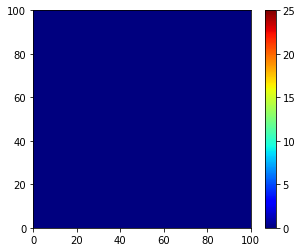

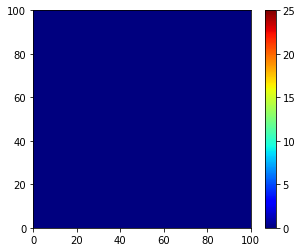

In [261]:
if isnotebook:
    labelViewer = fp.Viewer(vars=labels, datamin=0, datamax=25)
    labelViewer.plot()

### Define output routines

In [262]:
def saveStats(elapsed):
    if parallelComm.procID == 0:
        fname = os.path.join(path, 'stats.txt')
        if os.path.exists(fname):
            # backup before overwrite
            os.rename(fname, fname + ".save")
        try:
            nmx.savetxt(fname,
                        stats,
                        delimiter="\t",
                        comments='',
                        header="\t".join(["time", "fraction", "particle_count", "energy"]))
        except:
            # restore from backup
            os.rename(fname + ".save", fname)
        if os.path.exists(fname + ".save"):
            os.remove(fname + ".save")

def current_stats(elapsed):
    return [float(x) for x in [elapsed, phi.cellVolumeAverage, labels.num_features, F]]

def savePhi(elapsed):
    phi_value = phi.globalValue.reshape((nx, ny))
    if parallelComm.procID == 0:
        fname = os.path.join(path, "t={}.npz".format(elapsed))
        nmx.savez(fname, phi=phi_value)

def checkpoint_data(elapsed):
    saveStats(elapsed)
    savePhi(elapsed)

### Output initial condition

### Figure out when to save

In [263]:
checkpoints = (fp.numerix.arange(int(elapsed / args.checkpoint_interval),
                                 int(args.totaltime / args.checkpoint_interval))
               + 1) * args.checkpoint_interval

checkpoints.sort()

In [264]:
if args.restart is not None:
    fname = os.path.join(os.path.dirname(args.restart), "stats.txt")
    stats = nmx.loadtxt(fname, skiprows=1)
    stats = stats[stats[..., 0] <= elapsed].tolist()
else:
    stats = []
    stats.append(current_stats(elapsed))

checkpoint_data(elapsed)
    
if parallelComm.procID == 0:
    nmx.save(os.path.join(path, 'nucleii.npy'), nucleii, allow_pickle=False)

## Solve and output

In [265]:
times = fp.tools.concatenate([checkpoints, nucleii[..., 0]])
times.sort()
times = times[(times > elapsed) & (times <= args.totaltime)]

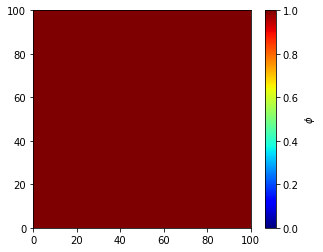

<Figure size 432x288 with 0 Axes>

In [266]:
from steppyngstounes import CheckpointStepper, FixedStepper

phi.updateOld()
for checkpoint in CheckpointStepper(start=elapsed,
                                    stops=times,
                                    stop=args.totaltime):

    for step in FixedStepper(start=checkpoint.begin,
                             stop=checkpoint.end,
                             size=1.):

        for sweep in range(args.sweeps):
            res = eq.sweep(var=phi, dt=step.size)

        phi.updateOld()
        stats.append(current_stats(step.end))

        _ = step.succeeded(error=res / 1e-3)

    for tt, xx, yy in nucleii[nucleii[..., 0] == checkpoint.end]:
        phi.setValue(phi + nucleus(x0=xx, y0=yy, r0=args.factor * 2))
        phi.setValue(1., where=phi > 1.)
        phi.updateOld()

    if checkpoint.end in checkpoints:
        # don't save nucleation events?
        checkpoint_data(checkpoint.end)

    if isnotebook:
        viewer.plot()
        # labelViewer.plot()

    _ = checkpoint.succeeded()

In [ ]:
checkpoint.end